In [1]:
!pip install Patchify


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os
from PIL import Image
import numpy as np
from patchify import patchify
from matplotlib import pyplot as plt
import random

In [3]:
!pip install -U segmentation-models


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [5]:

from keras import backend as K
from keras.models import load_model 
     

In [6]:

def jaccard_coef(y_true, y_pred):
  y_true_flatten = K.flatten(y_true)
  y_pred_flatten = K.flatten(y_pred)
  intersection = K.sum(y_true_flatten * y_pred_flatten)
  final_coef_value = (intersection + 1.0) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection + 1.0)
  return final_coef_value
     

In [7]:
weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]
dice_loss = sm.losses.DiceLoss(class_weights = weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

In [8]:
saved_model = load_model('Satellite Image Segmentation.h5',
                         custom_objects=({'dice_loss_plus_1focal_loss': total_loss, 
                                          'jaccard_coef': jaccard_coef}))


In [9]:

image = Image.open('Screenshot 2023-07-27 214554.jpg')
image = image.resize((256,256))
image = np.array(image)
image = np.expand_dims(image, 0)

In [10]:

prediction = saved_model.predict(image)

1/1 [==============================] - 0s 320ms/step


In [11]:

predicted_image = np.argmax(prediction, axis=3)
predicted_image = predicted_image[0,:,:]
     

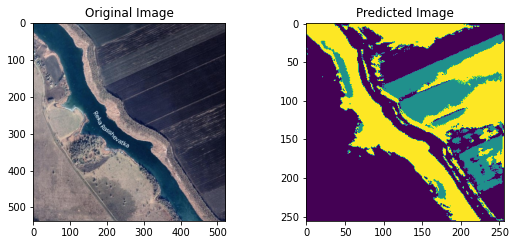

In [12]:

plt.figure(figsize=(14,8))
plt.subplot(231)
plt.title("Original Image")
plt.imshow(Image.open('Screenshot 2023-07-27 214554.jpg'))
plt.subplot(232)
plt.title("Predicted Image")
plt.imshow(predicted_image)
     

In [13]:
!pip install gradio


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [14]:
import gradio as gr

my_app = gr.Blocks()

In [15]:
def process_input_image(image_source):
    image = np.expand_dims(image_source, 0)
    prediction = saved_model.predict(image)
    predicted_image = np.argmax(prediction, axis=3)

    predicted_image = predicted_image[0,:,:]
    predicted_image = predicted_image * 50
    return 'Predicted Masked Image', predicted_image

In [16]:
     

with my_app:
    gr.Markdown("Satellite Image Segmentation Application UI with Gradio")
    with gr.Tabs():
        with gr.TabItem("Select your image"):
            with gr.Row():
                with gr.Column():
                    img_source = gr.Image(label="Please select source Image", shape=(256, 256))
                    source_image_loader = gr.Button("Load above Image")
                
                with gr.Column():
                    output_label = gr.Label(label="Image Info")
                    img_output = gr.Image(label="Image Output")
                    source_image_loader.click(
                        process_input_image,
                        [
                            img_source
                            ],
                        [
                            output_label,
                            img_output
                            ]
                        )

In [ ]:
my_app.launch(share=True,debug=True)

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://1ac93bdd507ac97d5f.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


1/1 [==============================] - 0s 91ms/step


In [ ]:
my_app.close()